# Iceland Litli-Hrútur Eruption Figures and Analysis



In [10]:
%matplotlib inline

import os, sys, math, datetime, time
import scipy.stats as stats
import rasterio
import numpy
from geopy.distance import geodesic
from scipy.integrate import quad
from rasterio.plot import show
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from sklearn.utils import shuffle
import datetime as dt
import matplotlib.transforms as transforms
from matplotlib import pyplot as plt
plt.rcParams.update({
    'text.usetex': False,
    'font.family': 'serif',
})

module_path = os.path.abspath('..')
if module_path not in sys.path:
    sys.path.append(module_path)

from dragonfly_util.mplogtocsv import parse_mplog
from dragonfly_util.logtocsv import parse_log
from dragonfly_util.ortho_map import OrthoMap
from dragonfly_util.plot_util import *
from dragonfly_util.reading import Reading

In [11]:
def read_data(file):
    return parse_log(file, skip_zeroing=False)

def filter_data(input, predicate):
    filtered = []
    for i in input:
        if predicate(i):
            filtered.append(i.data)
    return filtered

def between(start, end):
    start_date = datetime.datetime.strptime(start, '%Y-%m-%d %H:%M:%S.%f')
    end_date = datetime.datetime.strptime(end, '%Y-%m-%d %H:%M:%S.%f')
    return lambda value: value.type =='reading' and start_date <= value.date and end_date >= value.date and value.data.value > 0


df1_data = read_data("data/run.log")

day1 = filter_data(df1_data, between('2023-7-15 0:00:00.0', '2023-7-15 23:59:00.0'))
day2 = filter_data(df1_data, between('2023-7-16 0:00:00.0', '2023-7-17 23:59:00.0'))

day1_flight1 = filter_data(df1_data, between('2023-7-15 14:00:00.0', '2023-7-15 14:15:00.0'))

day2_flight1 = filter_data(df1_data, between('2023-7-16 17:20:00.0', '2023-7-16 17:26:00.0'))
day2_flight1a = filter_data(df1_data, between('2023-7-16 17:20:00.0', '2023-7-16 17:22:30.0'))
day2_flight1b = filter_data(df1_data, between('2023-7-16 17:22:30.0', '2023-7-16 17:26:00.0'))
day2_flight2 = filter_data(df1_data, between('2023-7-16 20:17:00.0', '2023-7-16 20:30:00.0'))

day2_flight2a = filter_data(df1_data, between('2023-7-16 20:18:30.0', '2023-7-16 20:19:00.0'))

In [18]:
def gaussian(amplitude, x, y, xmean, ymean, xstd_dev, ystd_dev):
    return amplitude * \
        (np.exp(- (((x - xmean) / xstd_dev) ** 2) / 2) / (xstd_dev * math.sqrt(2 * math.pi))) * \
        (np.exp(- (((y - ymean) / ystd_dev) ** 2) / 2) / (ystd_dev * math.sqrt(2 * math.pi)))

def gaussian_slice(amplitude, x, mean, std_dev):
    return gaussian(amplitude, x, 0, mean, 0, std_dev, std_dev)

def difference(distance_data, amplitude, mean, std_dev, ambient):
    difference_sum = 0
    for i in range(len(distance_data)) :
        if distance_data[i]["value"] > ambient:
            calculated_value = gaussian_slice(amplitude, distance_data[i]["distance"], mean, std_dev)
            calculated_difference = distance_data[i]["value"] - ambient
            difference = calculated_value - calculated_difference
            difference_sum = difference_sum + (difference ** 2)
    return difference_sum

def fit_data(distance_data, ambient, mean, std_dev, current, learning_rate, max_iter, precision=0.0000001):

    above_ambient_distance_data = [d for d in distance_data if d["value"] > ambient]
    x_values = [d["distance"] for d in above_ambient_distance_data]
    y_values = [d["value"] - ambient for d in above_ambient_distance_data]

    def gaussian(x, amplitude):
        return gaussian_slice(amplitude, x, mean, std_dev)

    params, covariance = curve_fit(gaussian, x_values, y_values, ftol=precision, p0=[current])

    a_fit = params[0]

    return a_fit, difference(distance_data, a_fit, mean, std_dev, ambient)


def flux(C):
    wind_speed = 10 # m/s
    seconds_in_day = 60 * 60 * 24 # s / day
    tonnes_per_g = math.pow(10, -6) # tonnes / g
    kg_per_g = math.pow(10, -3) # kg / g
    CO2_molecular_weight = 44.01 # g / mol
    l_per_m3 = 1000 # l / m3
    moles_per_m3 = l_per_m3 / 22.80 # mol / m3
    moles_per_liter = 1 / 22.80 # mol / l
    # g / mol * mol / l = g / l = g / 1000 m^3 = mg / m^3
    # (ppm m2)* (g / mol) * (mol / l) * (m/s) * (tonnes / g) * (s / day)
    # g CO2 m2 / m3 * (m/s) * (tonnes / g) * (s / day)
    # tonnes CO2 / day
#     return C * CO2_molecular_weight * moles_per_liter / l_per_m3 * wind_speed * tonnes_per_g * seconds_in_day
    return C * CO2_molecular_weight * moles_per_liter / l_per_m3 * wind_speed * kg_per_g

def area(distance_data, ambient):
        
    area_sum = 0
    size = len(distance_data)
    for i in range(size):
        if distance_data[i]["value"] > ambient:
            left = (distance_data[i-1]["distance"] + distance_data[i]["distance"]) / 2 if i > 0 else distance_data[i]["distance"]
            right = (distance_data[i]["distance"] + distance_data[i+1]["distance"]) / 2 if i < size - 1 else distance_data[i]["distance"]
            area_sum += (distance_data[i]["value"] - ambient) * abs(right - left)

    return area_sum

def render_scatter_areas(ax, distance_data, ambient):

    size = len(distance_data)
    for i in range(size):
        if distance_data[i]["value"] > ambient:
            left = (distance_data[i-1]["distance"] + distance_data[i]["distance"]) / 2 if i > 0 else distance_data[i]["distance"]
            right = (distance_data[i]["distance"] + distance_data[i+1]["distance"]) / 2 if i < size - 1 else distance_data[i]["distance"]
            ax.add_patch(Rectangle((left, ambient), right - left, distance_data[i]["value"] - ambient, color='lightsteelblue'))

EARTH_CIRCUMFERENCE = 40008000

def render_distance_data(starting_position, data, ambient, title, ax, min_distance=0, limit_distance=None, legend=True, use_max=False, plot_gaussian=True, max_co2=700, angle=math.pi/2, delegate=None):
    total = 0
    count = 0
    
    distance_data = []
    max_distance = 0
    distance_angle_scale = math.sin(angle)
    coord_start = (starting_position.lat, starting_position.lon)
    
    for d in data:
        coord_curr = (d.lat, d.lon)
        distance = geodesic(coord_start, coord_curr).meters
        if distance > min_distance:
            distance_data.append({"distance": distance, "value": d.value})
            if(distance > max_distance):
                max_distance = distance
            
    for i in range(len(distance_data)):
        if distance_data[i]["value"] > ambient:
            relative_co2 = distance_data[i]["value"] - ambient
            total = total + (relative_co2 * distance_data[i]["distance"])
            count = count + relative_co2
        
    mean = max_distance if use_max else total / count
    
    std_total = 0
    for i in range(len(distance_data)):
        if distance_data[i]["value"] > ambient:
            relative_co2 = distance_data[i]["value"] - ambient
            distance_diff = distance_data[i]["distance"] - mean
            std_total = std_total + (relative_co2 * (distance_diff * distance_diff))
    m = len(distance_data)
    
    std_dev = math.sqrt(std_total / (((m-1) / m) * count))

    [minimum_s, minimum_x2] = fit_data(distance_data, ambient, mean, std_dev, 4500, 100, 1000)
    
    scatter_area = area(distance_data, ambient)
    
    print("{} m: {:.2f} sd: {:.2f} a: {:.2f} x2: {:.2f} flux:{:.2f}kg/s".
          format(title, minimum_s, mean, std_dev, minimum_x2, flux(minimum_s)))
        
    x = np.linspace(mean - 5*std_dev, mean + 5*std_dev, 100)
    pdf = [(x) + ambient for x in gaussian_slice(minimum_s, x, mean, std_dev)]
    
    if delegate is not None:
        delegate(ax)
    
    ax.title.set_text(title)
    render_scatter_areas(ax, distance_data, ambient)
    ax.scatter([d["distance"] for d in distance_data], [d["value"] for d in distance_data], s=1, label="CO$_2$ readings")
    if plot_gaussian:
        ax.plot(x, pdf, c='r', label='Gaussian fit x2:{:.2f} flux:{:.2f}kg/s'.format(minimum_x2, flux(minimum_s)))
    ax.axhline(y = ambient, color = 'g', linestyle = '-.', label="Ambient threshold ({}ppm)".format(ambient))
    ax.set_xlabel('Distance East from takeoff (m)')
    ax.set_ylabel('CO$_2$ Concentration(ppm)')
    if limit_distance is not None:
        ax.set_aspect('auto')
        ax.set_xlim(0, limit_distance * distance_angle_scale)
        
    ax.set_ylim(400, max_co2)
    if legend:
        ax.legend()
    ax.plot()

def saveFigure(plt, name, dpi=72):
    figure_path = 'figures'
    if not os.path.exists(figure_path):
       os.makedirs(figure_path)
    plt.savefig(figure_path + "/" + name + ".pdf", format="pdf", dpi=dpi)
    plt.savefig(figure_path + "/" + name + ".png", format="png", dpi=dpi)
    
def display_data(name, readings, nlags=6):
    display_data_altitude(readings)
    
    display_readings(readings)

Day 2 Transect out m: 1911790.73 sd: 530.46 a: 25.33 x2: 335755.88 flux:3188.38kg/s
Day 2 Transect back m: 5139663.37 sd: 439.34 a: 65.09 x2: 721764.87 flux:8571.66kg/s


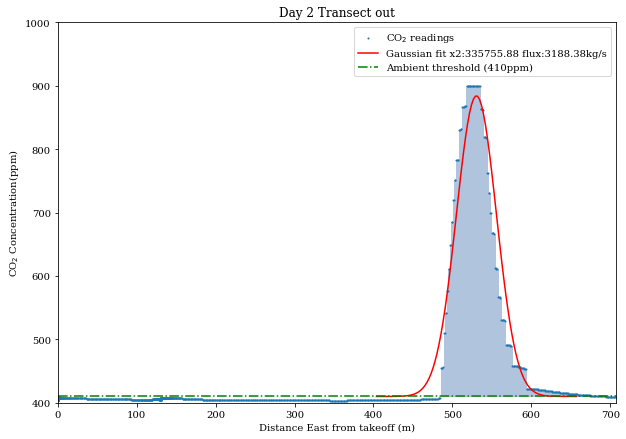

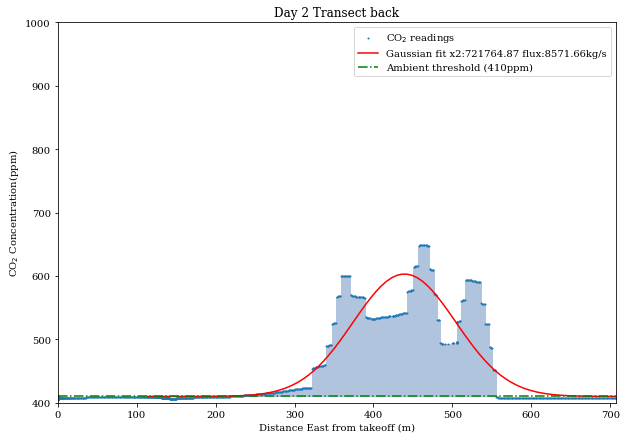

In [19]:
ig, axs = plt.subplots(1, 1, figsize=(10, 7))
render_distance_data(day2_flight1a[0], day2_flight1a, 410, 'Day 2 Transect out', axs, limit_distance=1000, max_co2=1000, legend=True, angle=math.pi/4)
saveFigure(plt, 'transect1', dpi=300)

ig, axs = plt.subplots(1, 1, figsize=(10, 7))
render_distance_data(day2_flight1a[0], day2_flight1b, 410, 'Day 2 Transect back', axs, limit_distance=1000, max_co2=1000, legend=True, angle=math.pi/4)
saveFigure(plt, 'transect2', dpi=300)

Day 2 Curtain m: 3504752.11 sd: 469.77 a: 29.45 x2: 3055289.71 flux:5845.04kg/s


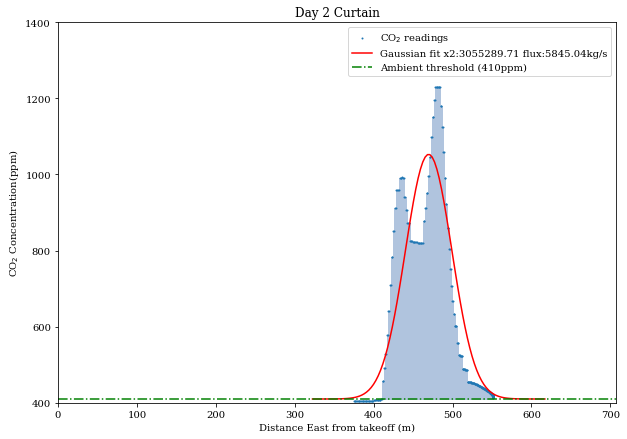

In [20]:
ig, axs = plt.subplots(1, 1, figsize=(10, 7))
render_distance_data(day2_flight1[0], day2_flight2a, 410, 'Day 2 Curtain', axs, limit_distance=1000, max_co2=1400, legend=True, angle=math.pi/4)
saveFigure(plt, 'transect3', dpi=300)

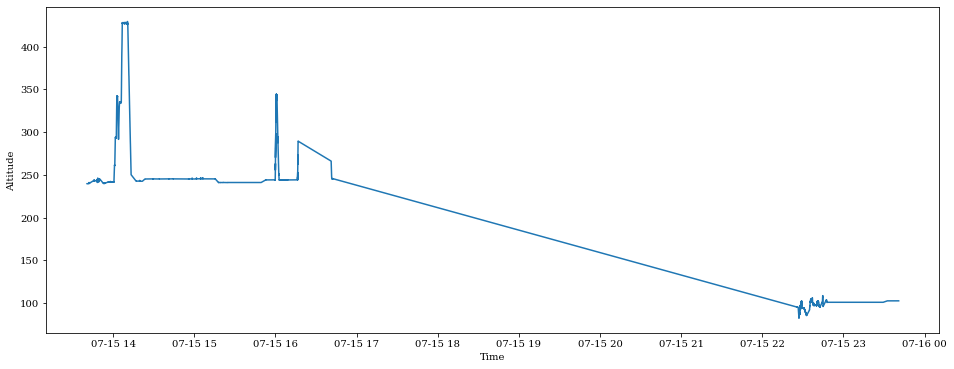

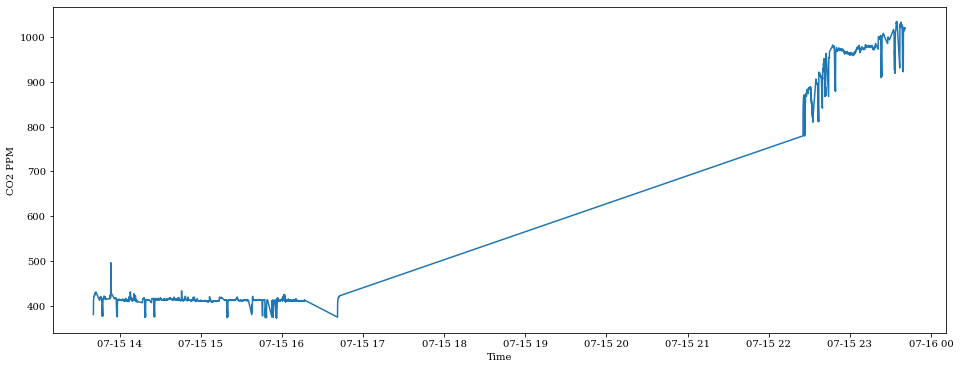

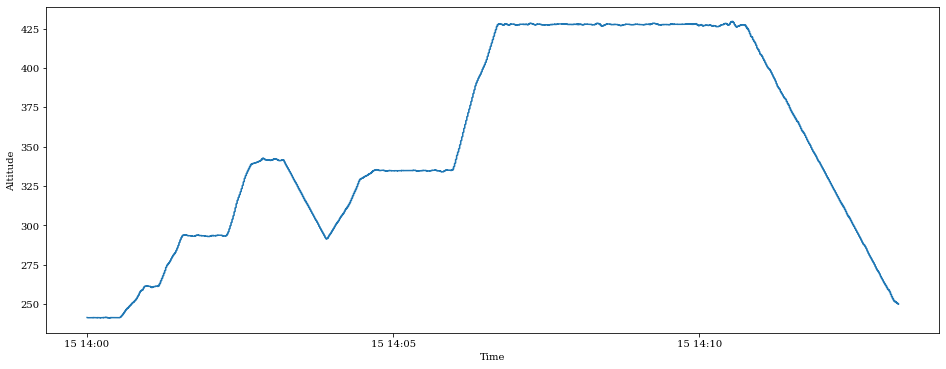

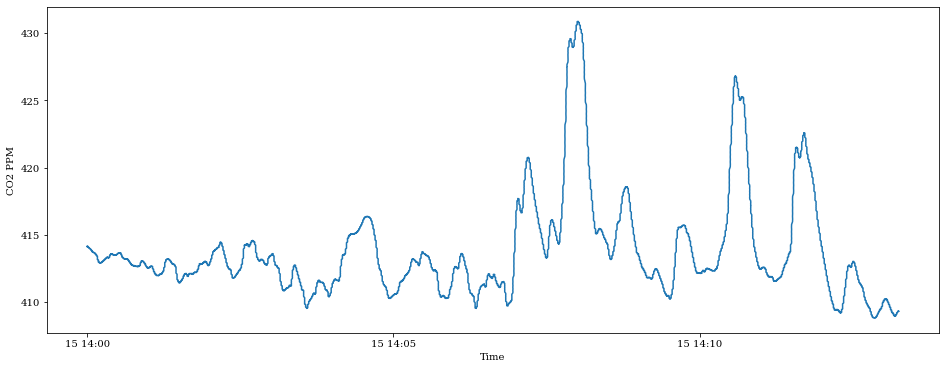

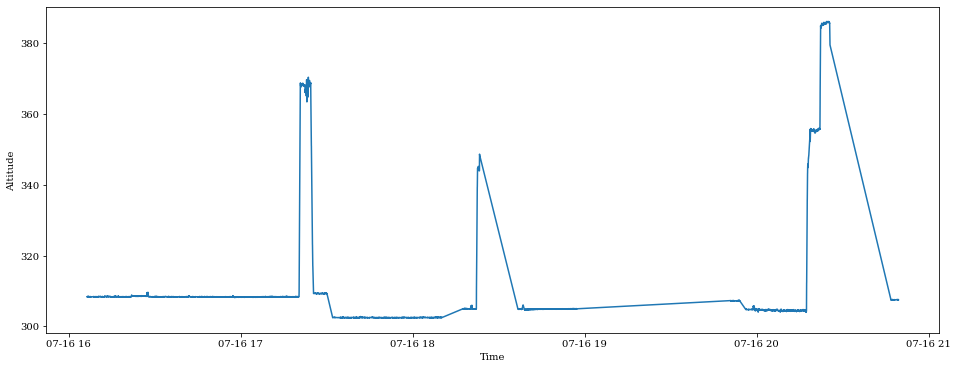

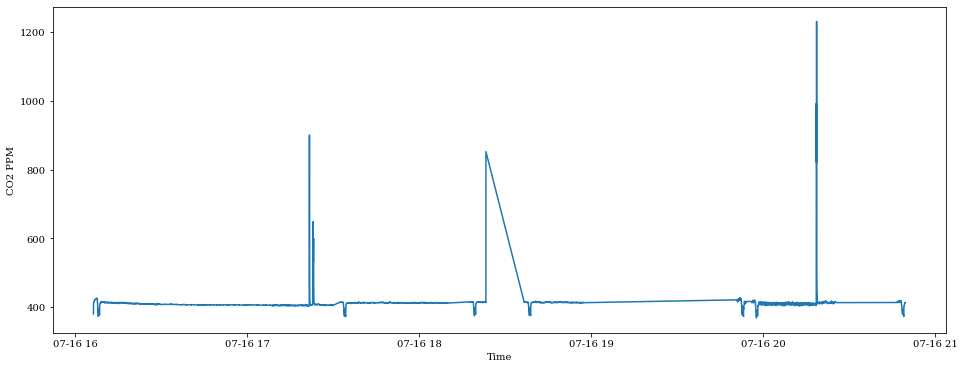

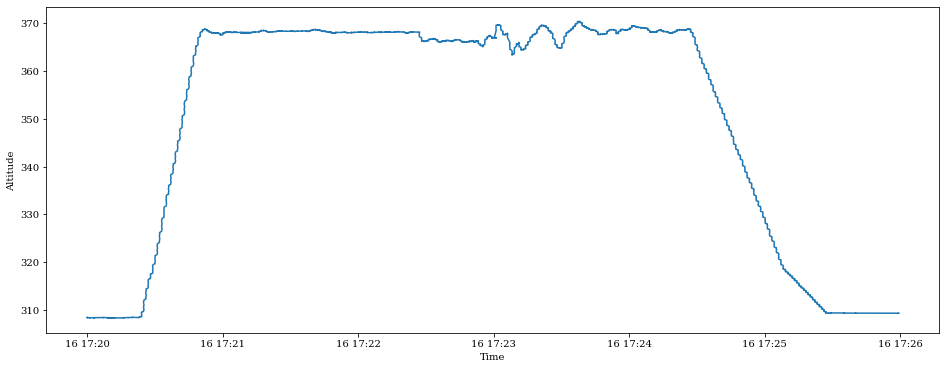

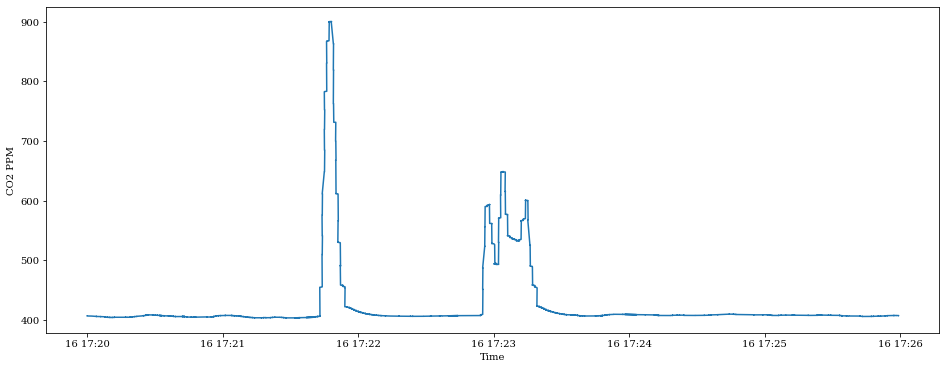

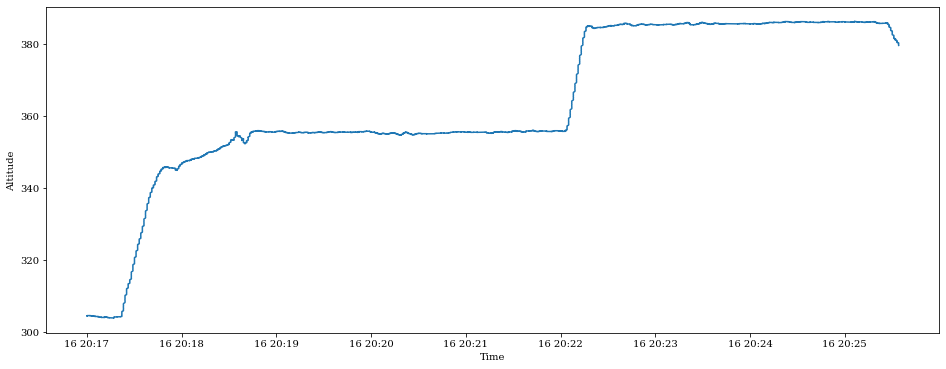

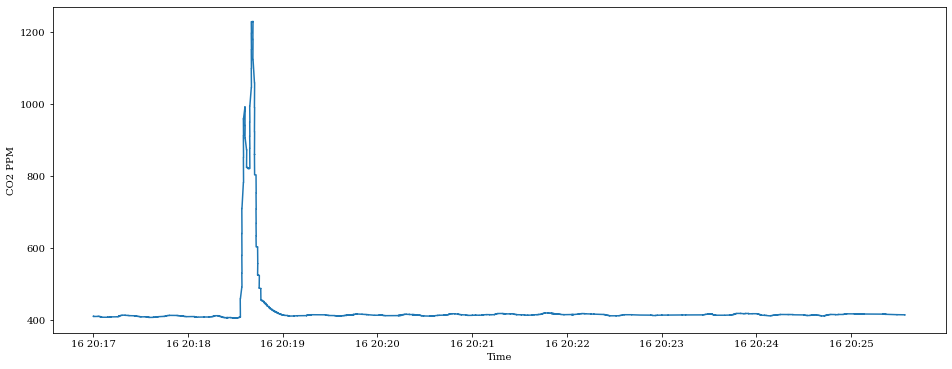

In [16]:
display_data('2023-7-15', day1)
display_data('2023-7-15', day1_flight1)
display_data('2023-7-16', day2)
display_data('2023-7-15', day2_flight1)
display_data('2023-7-15', day2_flight2)


In [17]:
from scipy.integrate import dblquad
import numpy as np

mean = 115348.14 
std_dev = 103.86
amplitude = 6.22

# Define the function to be integrated
def my_function(x, y):
    return gaussian(amplitude, x, y, mean, mean, std_dev, std_dev)

# Set the integration limits
lower_limit = mean - (10 * std_dev)
upper_limit = mean + (10 * std_dev)

# Calculate the definite integral
result, error = dblquad(my_function, lower_limit, upper_limit, lower_limit, upper_limit)

print(f"The definite integral result: {result}")
print(f"Estimated error in the result: {error}")


The definite integral result: 6.219999999999256
Estimated error in the result: 1.4381627643801222e-08
